# Qiskit Example
https://qiskit-community.github.io/qiskit-machine-learning/getting_started.html

Quantum Convolutional Neural Networks (QCNNs) behaves in a similar manner to classical convolutional neural netowrks (CCNNs). The first step of QCNNs is encoding an input data. After that, the alternating convolutional and pooling layers are applied.

In [1]:
# Import necessary libraries.
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 12345

## The target dataset of this example
In this example, the target dataset is 2x4 pixel images containing vertical or horizontal line constructed with two pixels. We use $\pi/2$ to represent the line pixel. For other pixels, we call them noisy background pixels, random values from $0$ to $\pi/4$ are assined. The QCNN is trained through supervised learning method so we will label each data $-1$ for the horizontal line and $+1$ for the vertical line.

We will end up build the QCNN classifying if the given image contains a vertical (or horizontal) line.

### My Simple Question
- Why was $\pi/2$ chosen as the value representing the line pixel?
- Why was the range from $0$ to $\pi/4$ chosen?
- Why were $-1$ and $+1$ chosen as labels?

In [2]:
# Define the dataset function.
def generate_dataset(
    num_images: int,
    line_pixel_value: float=np.pi/2,
    min_noise_value: float=0,
    max_noise_value: float=np.pi/4,
):
    # Define the hyper-params.
    image_shape = (2, 4)
    image_length = image_shape[0] * image_shape[1]  # The images are flattened to store.
    line_len = 2

    # Create all horizontal line patters.
    hor_shape = (6, image_length)
    hor_array = np.zeros(hor_shape)
    j = 0
    for i in range(0, 7):
        if i != 3:
            hor_array[j][i] = line_pixel_value
            hor_array[j][i+1] = line_pixel_value
            j += 1

    # Create all vertical line patterns.
    ver_shape = (4, image_length)
    ver_array = np.zeros(ver_shape)
    j = 0
    for i in range(0, 4):
        ver_array[j][i] = line_pixel_value
        ver_array[j][i+4] = line_pixel_value
        j += 1

    # Generate random images.
    images = []
    labels = []
    for n in range(num_images):
        rng = algorithm_globals.random.integers(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = algorithm_globals.random.integers(0, 6)
            images.append(np.array(hor_array[random_image]))
        elif rng == 1:
            labels.append(1)
            random_image = algorithm_globals.random.integers(0, 4)
            images.append(np.array(ver_array[random_image]))

        # Create noise.
        for i in range(8):
            if images[-1][i] == 0:
                images[-1][i] = algorithm_globals.random.uniform(min_noise_value, max_noise_value)

    return images, labels

In [3]:
images, labels = generate_dataset(50)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=246
)

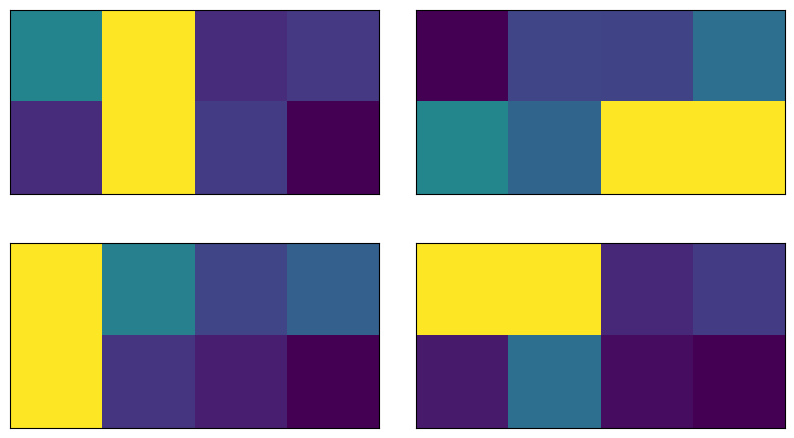

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i//2, i%2].imshow(
        train_images[i].reshape(2, 4),
        aspect="equal"
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

## The quantum convolutional layer
The quantum convolutional layer consists of a series of two-qubit of unitary gates. Each layer of those are parametrised and through the training session, the parameters will be updated to minimise a given const function.

In theory, any series of parameterised two-qubit unitary gates can be employed.

It is known that every unitary matrix $U$ in the unitary group $U(4)$, which is a group constructed with all 4x4 unitary matrices, can be decomposed such that
$$
U = (A_1 \otimes A_2) \cdot N(\alpha, \beta, \gamma) \cdot (A_3 \otimes A_4)
$$
where $A_j (j \in \{ 1, 2, 3, 4\})$ is an element in the special unitary group $SU(2)$. Any element in the special unitary group can be expressed with 3 free parameters. Also, 
$$
N(\alpha, \beta, \gamma) = \exp{(i [\alpha \sigma_x\sigma_x + \beta \sigma_y\sigma_y + \gamma \sigma_z\sigma_z])}.
$$
From the above discussion, every two-qubit unitary gate, which is expressed by a 4x4 unitary matrix, can be expressed with 15 parameters. That means, each unitary gate in the QCNN must contain 15 parameters each in order to span the whole Hilbert space. However, the larger parameters are had, the longer training time is needed. For the sake of the time, we will employ only $N(\alpha, \beta, \gamma)$. Remark the decomposition
$$
N(\alpha, \beta, \gamma) = (R_z(\pi/2) \otimes I)CNOT_{1,0}(I \otimes R_z(\lambda))CNOT_{0,1}(R_z(\theta) \otimes R_y(\phi))CNOT_{1,0}(I \otimes R_z(-\pi/2))
$$
holds, where $\alpha = \pi/2 - 2\theta, \beta = 2\phi - \pi/2$ and $\gamma = \pi/2 - 2\lambda$.

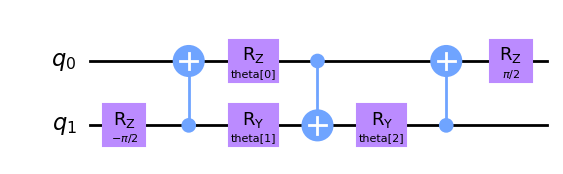

In [5]:
# Define the quantum convolutional unitary.
def conv_circuit(params: ParameterVector):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

# Draw the unitary.
params = ParameterVector("theta", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")

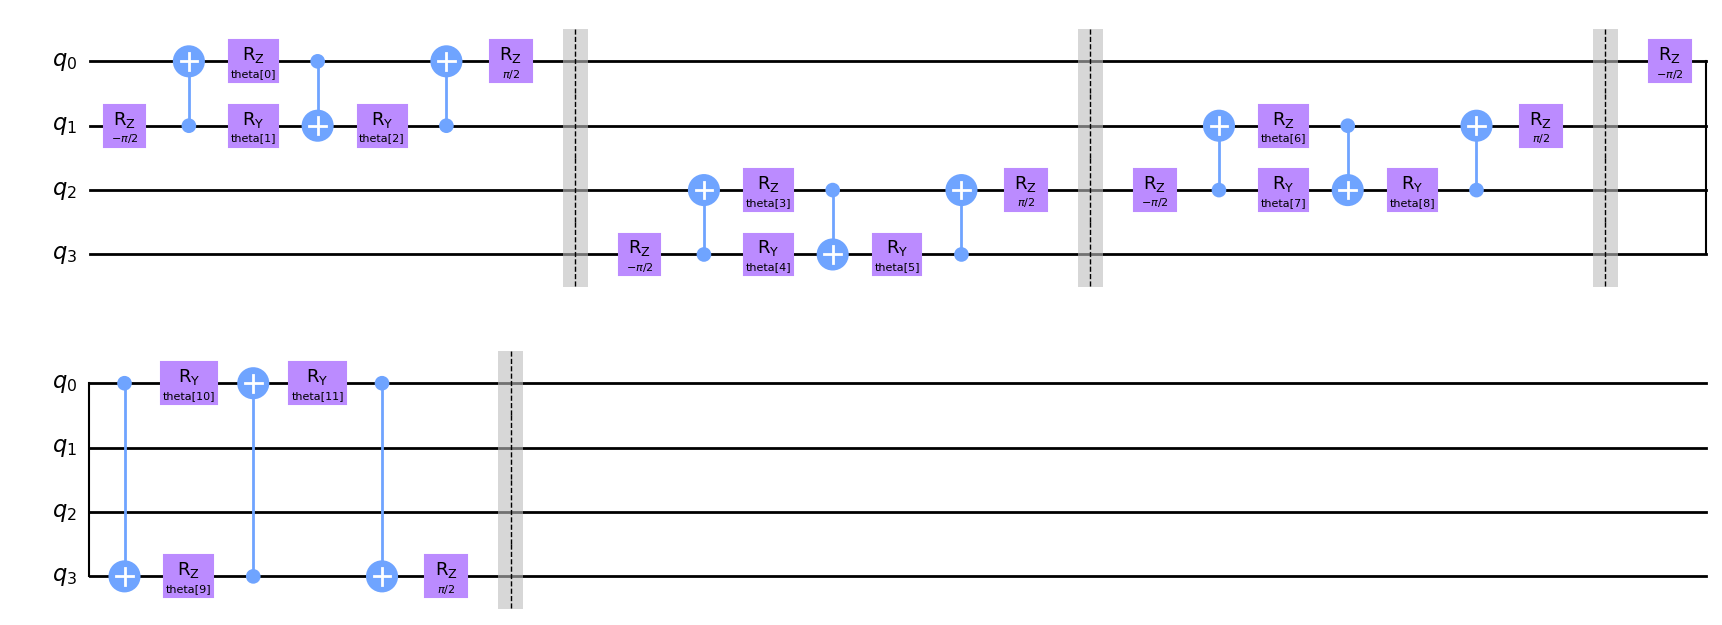

In [6]:
# Define the quantum convolutional layer.
def conv_layer(num_qubits: int, param_prefix: str):
    # This works if and only if the num_qubits is even.
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits*3)

    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index:(param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    
    return qc

circuit = conv_layer(4, "theta")
circuit.decompose().draw("mpl", style="clifford")

## The quantum pooling layer
In a classical manner, the pooling layer reduces the dimension of a given input data. However, we cannot simply do that as it means we need to reduce the number of qubits. So, we will "artificially" reduce the number of qubits, which means we will not use particular qubits after the quantum pooling layer. As the pooling circuit, we will again use the two-qubit generalised unitary circuit, yet the last two gates of it works on the "rubish" qubit, so we can omit them. As the pooling layer will be applied to a pair of two qubits, the "practical" number of qubits will be the half of the origin.

Note that, we could simple apply a dynamic circuit to reduce the dimensionality in the pooling layers. This qould involve performing measurements on certain qubits in the circuit and having an intermediate classical feedback loop in our pooling layers.

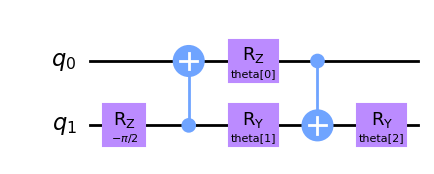

In [7]:
# Define the quantum pooling unitary.
def pool_circuit(params: ParameterVector):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

params = ParameterVector("theta", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

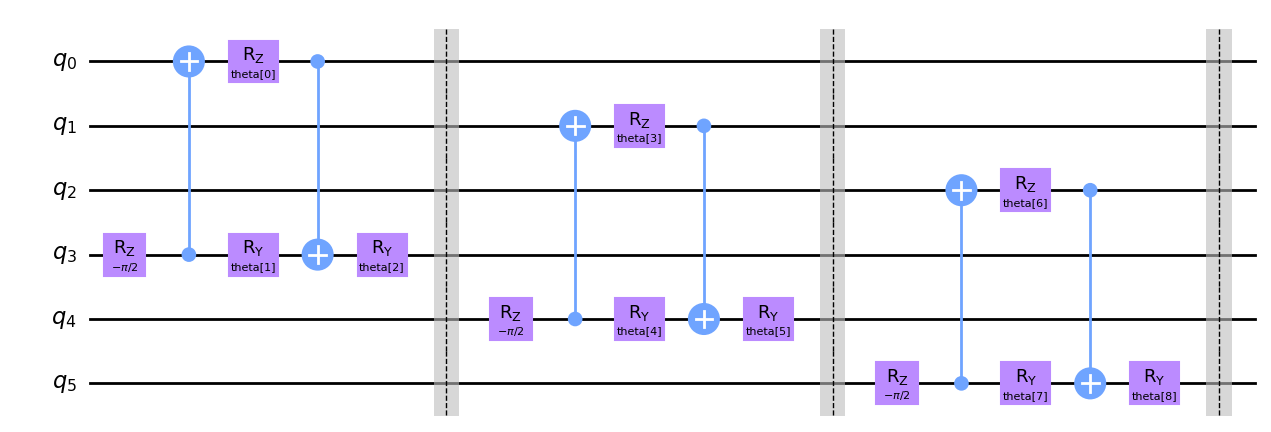

In [8]:
# Define the quantum pooling layer.
def pool_layer(sources: list[int], sinks: list[int], param_prefix: str):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)

    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index: (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

sources = [0, 1, 2]
sinks = [3, 4, 5]
circuit = pool_layer(sources, sinks, "theta")
circuit.decompose().draw("mpl", style="clifford")

## Modeling the QCNN
There are various encoding methods, yet here, we will use `ZFeatureMap` to encode our data.

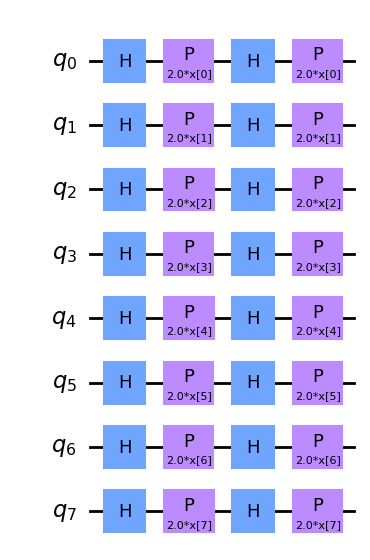

In [9]:
feature_map = ZFeatureMap(8)
feature_map.decompose().draw("mpl", style="clifford")

## Training the model

In [10]:
#Define the model.
data_size = 8

feature_map = ZFeatureMap(data_size)

# Create the ansatz.
ansatz = QuantumCircuit(data_size, name="Ansatz")
ansatz.compose(conv_layer(8, "conv1"), list(range(data_size)), inplace=True)
ansatz.compose(pool_layer([0,1,2,3], [4,5,6,7], "pool1"), list(range(data_size)), inplace=True)
ansatz.compose(conv_layer(4, "conv2"), list(range(4, data_size)), inplace=True)
ansatz.compose(pool_layer([0, 1], [2, 3], "pool2"), list(range(4, data_size)), inplace=True)
ansatz.compose(conv_layer(2, "conv3"), list(range(6, data_size)), inplace=True)
ansatz.compose(pool_layer([0], [1], "pool3"), list(range(6, data_size)), inplace=True)

# Combine the feature map and ansatz.
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(data_size), inplace=True)
circuit.compose(ansatz, range(data_size), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

qnn = EstimatorQNN(
    circuit = circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

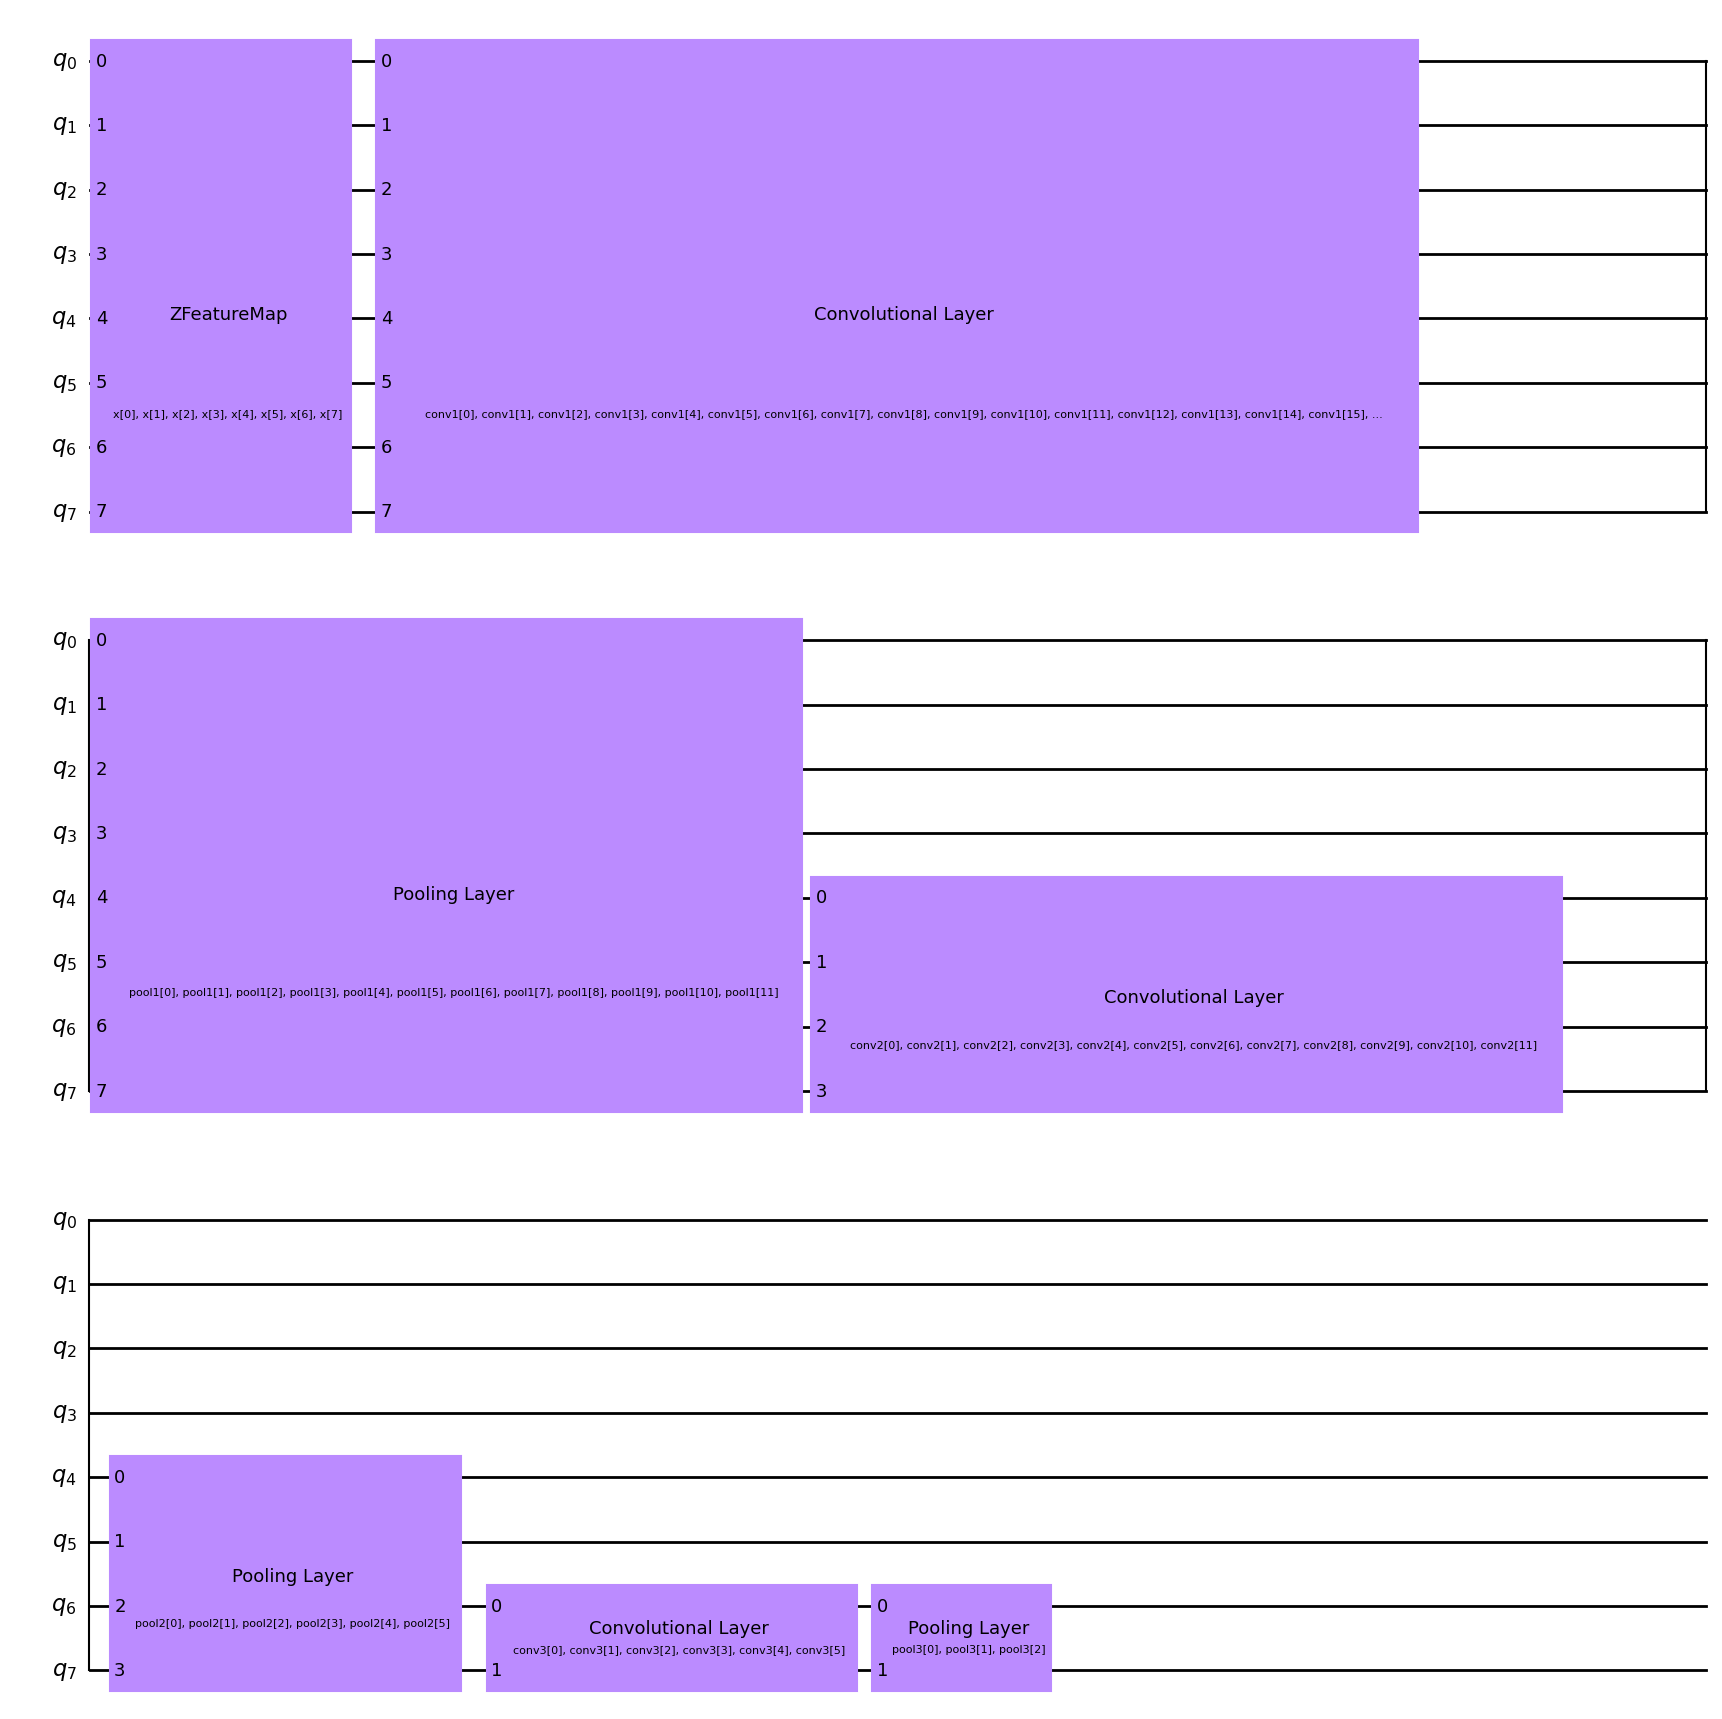

In [11]:
circuit.draw("mpl", style="clifford")

In [12]:
# Define our callback funcrtion.
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [13]:
# Create the classifier.
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=500),
    callback=callback_graph,
)

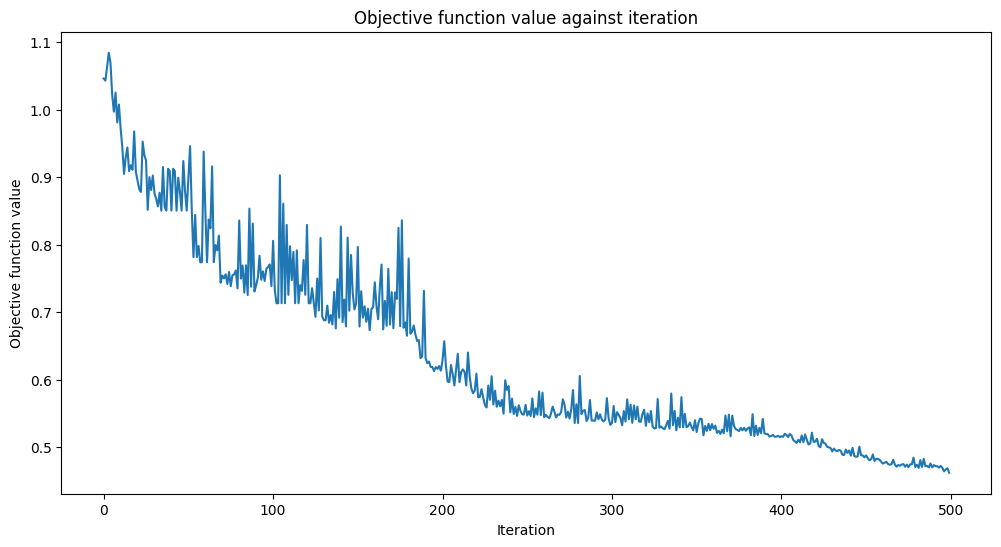

Accuracy from the train data : 94.29%


In [14]:
# Train the model.
x = np.asarray(train_images)
y = np.asarray(train_labels)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

## Testing the QCNN

Accuracy from the test data: 100.0%


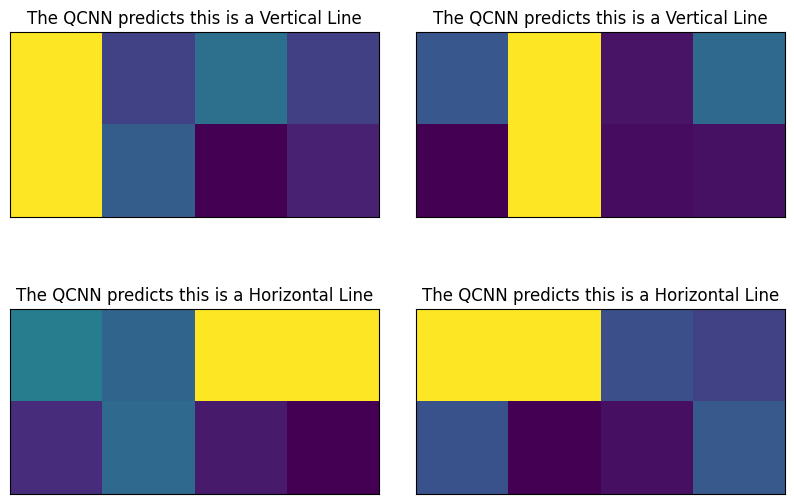

In [15]:
y_predict = classifier.predict(test_images)
x = np.asarray(test_images)
y = np.asarray(test_labels)
print(f"Accuracy from the test data: {np.round(100 * classifier.score(x, y), 2)}%")

fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(test_images[i].reshape(2, 4), aspect="equal")
    if y_predict[i] == -1:
        ax[i // 2, i%2].set_title("The QCNN predicts this is a Horizontal Line")
    if y_predict[i] == +1:
        ax[i // 2, i%2].set_title("The QCNN predicts this is a Vertical Line")

plt.subplots_adjust(wspace=0.1, hspace=0.5)

This code is a part of a Qiskit project
© Copyright IBM 2017, 2024.